In [1]:
%matplotlib inline
import sys
from urllib2 import Request, urlopen, URLError
import requests
import time
from pyproj import Proj
p1 = Proj(init='epsg:26915')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # makes plots pretty
import pandas as pd
import numpy as np
from xml.etree import cElementTree as ET
import re

from sql import *
import sqlite3

from matplotlib import dates, pyplot
import pytz
import datetime as DT
from datetime import datetime

import pylab as pl
from IPython import display
#matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [2]:


def get_central_time():
    central = pytz.timezone('US/Central')
    test = datetime.utcnow()
    c_time = central.localize(test).strftime('%H:%M:%S%z')
    
    m = int(c_time[3:5])
    m_o = int(c_time[-2:])
    h = int(c_time[:2])
    h_o = int(c_time[-4:-2])
    if m_o>m:
        m = 60+(m-m_o)
        h_o = h_o+1
    else:
        m = m-m_o

    if h_o>h:
        h = 24+(h-h_o)
    else:
        h = h-h_o

    c_time = '{:02d}:{:02d}:{!s}'.format(h, m, c_time[6:8])


    return c_time

c_time = get_central_time()

central = pytz.timezone('US/Central')
test = datetime.utcnow()
weekday_list = ['sunday','monday','tuesday','wednesday','thursday','friday','saturday']
weekday = weekday_list[int(central.localize(test).strftime('%w'))]


In [3]:
print test

2016-02-03 17:53:08.209664


In [186]:
con =  sqlite3.connect('/home/vagrant/datacourse/Capstone/CTA_GTFS/CTA_Sched')

query1 = '''SELECT route_id, trip_id, service_id, shape_id FROM Trips WHERE route_id == '66'  '''
query2 = '''SELECT route_id, trip_id, trip_id/100000000 AS trip_id_trunc1,(trip_id-((trip_id/100000000)*100000000))/10000 AS trip_id_trunc2, trip_id%10000 AS trip_id_trunc3, RT66.service_id AS service_id, shape_id
            FROM ('''+query1+''') AS RT66 JOIN Calendar ON RT66.service_id = Calendar.service_id WHERE '''+weekday+''' == 1'''

query3 = '''
                SELECT * FROM (
                SELECT  route_id, MIN(arrival_time) AS start_time, MAX(arrival_time) AS end_time, trip_id_trunc1, trip_id_trunc2, trip_id_trunc3,  service_id, shape_id, StopTimes.trip_id AS trip_id
                    FROM ('''+query2+''') AS RT66Day JOIN StopTimes ON RT66Day.trip_id == StopTimes.trip_id GROUP BY RT66Day.trip_id 
                )
                GROUP BY trip_id_trunc2, trip_id_trunc3, start_time ORDER BY route_id, start_time ASC'''  
Rt66Trips = pd.read_sql_query(query3, con)
print Rt66Trips

    route_id start_time  end_time  trip_id_trunc1  trip_id_trunc2  \
0         66   00:00:00  00:43:34            4600            9687   
1         66   00:00:58  00:45:42            4600            9687   
2         66   00:12:58  00:57:42            4600            9687   
3         66   00:13:28  00:23:30            4600            9687   
4         66   00:14:58  01:03:30            4600            9687   
5         66   00:23:28  00:33:30            4600            9687   
6         66   00:25:58  01:10:42            4600            9687   
7         66   00:39:58  01:24:42            4600            9687   
8         66   00:44:58  01:33:30            4600            9687   
9         66   00:46:28  00:56:30            4600            9687   
10        66   00:54:58  01:36:42            4600            9687   
11        66   01:09:54  01:46:30            4600            9687   
12        66   01:11:28  01:21:30            4600            9687   
13        66   01:14:58  02:03:30 

In [10]:

sh_u = list(Rt66Trips['shape_id'].unique())
print len(sh_u), sh_u

16 [u'4606662', u'4606665', u'4606982', u'4606661', u'4604344', u'4604353', u'4606658', u'4604601', u'4604602', u'4606660', u'4604355', u'4604603', u'4606659', u'4604347', u'4604357', u'4607391']


In [4]:
def p2p_dist(v, w):
    return ((v[0]-w[0])**2 + (v[1]-w[1])**2)**0.5

In [188]:
stops = pd.DataFrame()
for i in range(len(Rt66Trips)):
    query_st = '''SELECT StopsSel.stop_id AS stop_id, stop_lat, stop_lon FROM (
                        SELECT stop_id
                            FROM StopTimes WHERE trip_id == '''+Rt66Trips['trip_id'].loc[i]+'''  
                            ) AS StopsSel JOIN Stops ON StopsSel.stop_id == Stops.stop_id GROUP BY StopsSel.stop_id 
        '''
    stops_t = pd.read_sql_query(query_st, con)
    stops_t.set_index(stops_t['stop_id'], inplace=True)
    stops = pd.concat([stops, stops_t], ignore_index=False, copy=False).drop_duplicates()
stops['x'], stops['y'] = p1( np.array(stops['stop_lon']), np.array(stops['stop_lat']))
print stops
    

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

In [18]:
print stops

Empty DataFrame
Columns: []
Index: []


In [4]:
def update_vehicle_dict(D, D_comp, response):
    central = pytz.timezone('US/Central')
    test = datetime.utcnow()
    date = central.localize(test).strftime('%Y%m%d')
    out = ''
    try:
        out = urlopen(response.url).read()
        root = ET.fromstring(out)
    except:
        return D, D_comp
    #print urlopen(response.url).read()
    if root[0].tag == 'error':
#        print 'API ERROR'
        return D, D_comp
    try:
        rt = root.find('vehicle').find('rt').text
    except:
        print 'READ XML ERROR', out
        return D, D_comp
#    print rt
    seen = [rt+ '_'+ vehicle.find('tatripid').text for vehicle in root.findall('vehicle')]
    if rt+'_last_seen' not in D_comp.keys():
        conn = sqlite3.connect('API_Scrape.db')
        c = conn.cursor()

        c.execute('''CREATE TABLE API_DAT
             (id, x, y, t)''')
        conn.commit()
        conn.close()

        D_comp[rt+'_last_seen'] = []
    old_keys = [rt+'_'+i.split('_')[-1] for i in D_comp[rt+'_last_seen']]
    new_keys = [i for i in seen if i not in old_keys]
    rm = set(old_keys)-set(seen)
    D_comp[rt+'_last_seen'] = seen
    for vehicle in root.findall('vehicle'):
        t_id = rt+'_'+vehicle.find('tatripid').text
        if t_id in new_keys:
            t_id = date + '_' + t_id
#            D[t_id] = {}
            D_comp[t_id] = {}
            D_comp[t_id]['x'] = []
            D_comp[t_id]['y'] = []
            new_x, new_y = p1( vehicle.find('lon').text, vehicle.find('lat').text )
            D_comp[t_id]['x'].append(new_x)
            D_comp[t_id]['y'].append(new_y)
            D_comp[t_id]['t'] = [vehicle.find('tmstmp').text]
#            for child in vehicle:
#                D[t_id][child.tag] = child.text
        else:
            t_id = sorted([s for s in D_comp.keys() if re.match('(.*'+t_id+')$', s)], reverse=True)[0]
            new_t = vehicle.find('tmstmp').text
            if new_t != D_comp[t_id]['t'][-1]:
                new_x, new_y = p1( vehicle.find('lon').text, vehicle.find('lat').text )
                D_comp[t_id]['x'].append(new_x)
                D_comp[t_id]['y'].append(new_y)
                D_comp[t_id]['t'].append(vehicle.find('tmstmp').text)
#            for child in vehicle:
#                D[t_id] = {}
#                D[t_id][child.tag] = child.text

    if rm:

        conn = sqlite3.connect('API_Scrape.db')
        c = conn.cursor()
        for t_id in rm:
            t_id = sorted([s for s in D_comp.keys() if re.match('(.*'+t_id+')$', s)], reverse=True)[0]
            tups = [(id_, x, y, t) for id_, x, y, t in zip( [t_id]*len(D_comp[t_id]['x']), D_comp[t_id]['x'], D_comp[t_id]['y'], D_comp[t_id]['t'] )]
            D_comp.pop(t_id, None)
#            D.pop(t_id, None)
            c.executemany("INSERT INTO API_DAT VALUES (" + ','.join(['?']*len( tups ))+")", tups)
        #    print tups
        conn.commit()
        conn.close()

        #[D.pop(i, None) for i in rm]
    return D, D_comp




In [10]:
base_url = 'http://www.ctabustracker.com/bustime/api/v1/'
route_str = 'getvehicles'
dev_str = 'iwAameW6cVPbv4PTdka8KEu3b'
rts_url = base_url+'getroutes'+ '?key='+dev_str
request = Request(rts_url)
response = urlopen(request)
out = response.read()
#print out
root = ET.fromstring(out)
print out
rts_xml = root.findall("./route/rt")
rts = [rts_xml[i].text for i in range(len(rts_xml))]
print len(rts)
print rts

<?xml version="1.0"?>
<bustime-response><error><msg>Transaction limit for current day has been exceeded.</msg></error></bustime-response>

	
0
[]


In [6]:
base_url = 'http://www.ctabustracker.com/bustime/api/v1/'
route_str = 'getvehicles'
dev_str = 'iwAameW6cVPbv4PTdka8KEu3b'
rts_url = base_url+'getroutes'+ '?key='+dev_str
j = 0
D = {}
D_comp = {}
#request = Request(rts_url)
response = urlopen(request)
out = response.read()
root = ET.fromstring(out)
rts_xml = root.findall("./route/rt")
rts = [rts_xml[i].text for i in range(len(rts_xml))]
urls = [base_url+route_str+'?key='+dev_str + '&rt='+ i for i in rts]
from requests_futures.sessions import FuturesSession
while j<10:
    j = j+1
    session = FuturesSession(max_workers=5)
    
    urls = [base_url+route_str+'?key='+dev_str + '&rt='+ '66']


    futures = [session.get(url) for url in urls[-1:]]
    for future in futures:
        D, D_comp = update_vehicle_dict(D, D_comp,future.result())
        time.sleep(0.01)
    time.sleep(120)
print D_comp

[('20160203_7_1000826', 934502.0094883192, 4648899.909279641, '20160203 11:43')]
[('20160203_9_10001851', 944010.1305989911, 4632512.8015663335, '20160203 11:43')]
[('20160203_12_1074686', 946381.1470880765, 4648548.743422426, '20160203 11:43')]
[('20160203_20_1040544', 946059.078970249, 4650682.075548189, '20160203 11:44')]
[('20160203_47_133', 936783.3751981263, 4640715.895839651, '20160203 11:44')]
[('20160203_49_10001334', 942158.0798152842, 4635782.024037793, '20160203 11:43')]
[('20160203_63W_1020867', 937242.2461221887, 4639462.034262415, '20160203 11:44')]
[('20160203_67_168', 948388.570821628, 4638637.33528327, '20160203 11:44')]
[('20160203_70_379', 945489.1883406227, 4652813.806529928, '20160203 11:44')]
[('20160203_75_181', 942816.7980406781, 4636804.626005006, '20160203 11:43')]
[('20160203_85_318', 933897.289374148, 4656241.312225217, '20160203 11:43')]
[('20160203_86_54', 932185.9835846393, 4657701.716392888, '20160203 11:45')]
[('20160203_111_1029846', 944317.2979695031

In [134]:
APPTOK = 'KlzvLDEKWVfSGdFFMzUdViRkH'
traf_json = []
for i in range(1284, 1292):
    SODA_traffic = 'https://data.cityofchicago.org/resource/77hq-huss.json?segment_id='+str(i)+'&$limit=50000'
    r = requests.get(SODA_traffic,  headers={"X-App-Token":APPTOK})
    print type(r.json())
    print len(r.json())
    traf_json.extend(r.json())
traf_df = pd.DataFrame(traf_json)

<type 'list'>
99
<type 'list'>
11615
<type 'list'>
11615
<type 'list'>
11615
<type 'list'>
11615
<type 'list'>
11615
<type 'list'>
11615
<type 'list'>
11615


In [136]:
print traf_df

      bus_count                                        id  \
0           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
1           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
2           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
3           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
4           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
5           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
6           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
7           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
8           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
9           NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
10          NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
11          NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
12          NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
13          NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
14          NaN  5988ff430ad77c56fbcac4b0014cac31a2f93d25   
15          NaN  5988ff4

In [147]:
traf_df2 = traf_df[traf_df['traffic']!='-1']
traf_df2 = traf_df2.dropna(subset=['traffic']) 

In [184]:
traf_df2['segment_id'] = traf_df2['segment_id'].apply(lambda x: int(x))
traf_df2['traffic'] = traf_df2['traffic'].apply(lambda x: int(x))
traf_df2['msg_count'] = traf_df2['msg_count'].apply(lambda x: int(x))

traf_g = traf_df2[['msg_count', 'segment_id', 'traffic', 'last_update']]

print len(traf_g)

68038


In [193]:
import datetime
traf_g['sum_speed'] = traf_g['msg_count'].multiply(traf_g['traffic'])
traf_g['hour'] = traf_g['last_update'].apply(lambda x: int(x[11:13]))
traf_g['weekday'] = traf_g['last_update'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S').strftime('%a'))
print min(traf_g['hour']), max(traf_g['hour'])
print traf_g



23 23
       msg_count  segment_id  traffic          last_update  sum_speed  hour  \
99             2        1285       22  2014-12-20T23:50:32         44    23   
100            8        1285       19  2014-11-28T23:50:32        152    23   
101            1        1285       22  2014-12-10T23:50:32         22    23   
103            1        1285       22  2013-02-11T23:50:32         22    23   
104            5        1285       20  2013-02-09T23:50:32        100    23   
106            3        1285       10  2014-12-20T23:50:32         30    23   
108           11        1285        7  2014-12-03T23:50:32         77    23   
111            1        1285       22  2014-11-25T23:50:32         22    23   
112            1        1285       22  2013-02-28T23:50:32         22    23   
113           29        1285       20  2014-12-18T23:50:32        580    23   
114            3        1285       16  2014-12-01T23:50:32         48    23   
115            2        1285       22  2014-12

In [202]:
import matplotlib.pyplot as plt
import numpy as np
import random
segs = ['Michigan LSD East', 
       'LaSalle Michigan West',
       'LaSalle Michigan East',
       'Halsted LaSalle West',
       'Halsted LaSalle East', 
       'Milwaukee Halsted West',
       'Milwaukee Halsted East']
data = {}
data[segs[0]] = traf_g[traf_g['segment_id']==1285]
data[segs[1]] = traf_g[traf_g['segment_id']==1286]
data[segs[2]] = traf_g[traf_g['segment_id']==1287]
data[segs[3]] = traf_g[traf_g['segment_id']==1288]
data[segs[4]] = traf_g[traf_g['segment_id']==1289]
data[segs[5]] = traf_g[traf_g['segment_id']==1290]
data[segs[6]] = traf_g[traf_g['segment_id']==1291]

In [203]:
print data

{'Milwaukee Halsted East':        msg_count  segment_id  traffic          last_update  sum_speed  hour  \
69789          5        1291       23  2014-12-29T23:50:32        115    23   
69792         12        1291       23  2014-12-17T23:50:32        276    23   
69793          9        1291       21  2013-01-30T23:50:32        189    23   
69794         10        1291       20  2014-12-06T23:50:32        200    23   
69795          7        1291       23  2014-12-23T23:50:32        161    23   
69797         12        1291       25  2014-12-27T23:50:32        300    23   
69798          6        1291       20  2014-11-29T23:50:32        120    23   
69799          2        1291       25  2014-12-30T23:50:32         50    23   
69800          6        1291       28  2013-01-25T23:50:32        168    23   
69801         14        1291       20  2013-01-29T23:50:32        280    23   
69802          1        1291       25  2013-02-25T23:50:32         25    23   
69803          6        1

In [206]:
print data.keys()


['Milwaukee Halsted East', 'LaSalle Michigan East', 'Michigan LSD East', 'Halsted LaSalle West', 'Milwaukee Halsted West', 'LaSalle Michigan West', 'Halsted LaSalle East']


In [212]:

v = {}

for k in data.keys():
    v[k] = {}
    v[k]['Mon'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Mon']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Mon']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Mon']['msg_count'].tolist())
    v[k]['Tue'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Tue']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Tue']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Tue']['msg_count'].tolist())
    v[k]['Wed'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Wed']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Wed']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Wed']['msg_count'].tolist())
    v[k]['Thu'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Thu']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Thu']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Thu']['msg_count'].tolist())
    v[k]['Fri'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Fri']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Fri']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Fri']['msg_count'].tolist())
    v[k]['Sat'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Sat']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Sat']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Sat']['msg_count'].tolist())
    v[k]['Sun'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Sun']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Sun']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Sun']['msg_count'].tolist())

In [213]:
print v

{'Milwaukee Halsted East': {'Wed': 21, 'Sun': 22, 'Fri': 21, 'Tue': 20, 'Mon': 21, 'Thu': 21, 'Sat': 23}, 'LaSalle Michigan East': {'Wed': 15, 'Sun': 16, 'Fri': 14, 'Tue': 15, 'Mon': 15, 'Thu': 15, 'Sat': 15}, 'Michigan LSD East': {'Wed': 18, 'Sun': 18, 'Fri': 17, 'Tue': 17, 'Mon': 17, 'Thu': 17, 'Sat': 18}, 'Halsted LaSalle West': {'Wed': 17, 'Sun': 19, 'Fri': 17, 'Tue': 16, 'Mon': 17, 'Thu': 17, 'Sat': 19}, 'Milwaukee Halsted West': {'Wed': 18, 'Sun': 21, 'Fri': 18, 'Tue': 19, 'Mon': 19, 'Thu': 19, 'Sat': 21}, 'LaSalle Michigan West': {'Wed': 14, 'Sun': 15, 'Fri': 14, 'Tue': 14, 'Mon': 14, 'Thu': 15, 'Sat': 14}, 'Halsted LaSalle East': {'Wed': 17, 'Sun': 19, 'Fri': 17, 'Tue': 17, 'Mon': 17, 'Thu': 17, 'Sat': 19}}


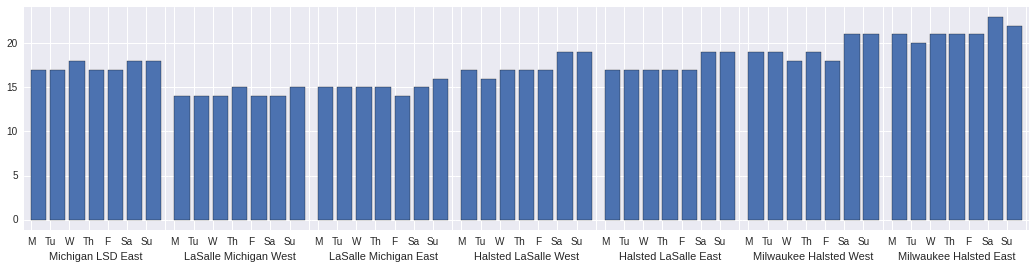

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import random
segs = ['Michigan LSD East', 
       'LaSalle Michigan West',
       'LaSalle Michigan East',
       'Halsted LaSalle West',
       'Halsted LaSalle East', 
       'Milwaukee Halsted West',
       'Milwaukee Halsted East']
data = {}
data[segs[0]] = traf_g[traf_g['segment_id']==1285]
data[segs[1]] = traf_g[traf_g['segment_id']==1286]
data[segs[2]] = traf_g[traf_g['segment_id']==1287]
data[segs[3]] = traf_g[traf_g['segment_id']==1288]
data[segs[4]] = traf_g[traf_g['segment_id']==1289]
data[segs[5]] = traf_g[traf_g['segment_id']==1290]
data[segs[6]] = traf_g[traf_g['segment_id']==1291]



v = {}

for k in data.keys():
    v[k] = {}
    v[k]['Mon'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Mon']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Mon']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Mon']['msg_count'].tolist())
    v[k]['Tue'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Tue']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Tue']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Tue']['msg_count'].tolist())
    v[k]['Wed'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Wed']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Wed']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Wed']['msg_count'].tolist())
    v[k]['Thu'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Thu']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Thu']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Thu']['msg_count'].tolist())
    v[k]['Fri'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Fri']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Fri']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Fri']['msg_count'].tolist())
    v[k]['Sat'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Sat']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Sat']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Sat']['msg_count'].tolist())
    v[k]['Sun'] = np.sum(np.multiply(data[k][data[k]['weekday'] == 'Sun']['traffic'].tolist(), 
                              data[k][data[k]['weekday'] == 'Sun']['msg_count'].tolist()))/ \
                        np.sum(data[k][data[k]['weekday'] == 'Sun']['msg_count'].tolist())
plt.figure(figsize = (8, 4))
fig, axes = plt.subplots(ncols=7, sharey=True, figsize = (18, 4))
fig.subplots_adjust(wspace=0)


for ax, name in zip(axes, segs):
    ax.bar(range(0,7), [v[name][item] for item in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']])
    ax.set(xticklabels=[' ','M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su'], xlabel=name)
    ax.margins(0.05)

plt.show()
        

In [178]:

traf_g_t = traf_g.groupby(['segment_id'])[['sum_speed', 'msg_count']].agg(['sum' ])

In [183]:
traf_g_t['avg_speed'] = traf_g_t['sum_speed']['sum'].divide(traf_g_t['msg_count']['sum'])
print traf_g_t

           sum_speed msg_count  avg_speed
                 sum       sum           
segment_id                               
1285         1365291     76020  17.959629
1286         2816095    189057  14.895481
1287         3330279    216890  15.354691
1288         3136278    175151  17.906138
1289         4024712    223395  18.016124
1290         1806162     92826  19.457501
1291         1616172     74990  21.551834
